## И снова к началам,  У НАС ЕСТЬ НАД ЧЕМ ПОДУМАТЬ 

Может в этом есть причина в том, что есть области с дичью и при восстановлении с помощью LM я снова задумалась об унификации процесса

In [213]:
import sys
sys.path.append('..')
from astropy.io import fits
from scipy.optimize import curve_fit
from inverse_problem.milne_edington.me import HinodeME, BatchHinodeME
from inverse_problem import me_model
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline

## Модель атмосферы

Модель атмосферы у нас лежит в папочке milne_edington/me.py Там есть функция собственно модели атмосферы, туда надо передать параметры линий и параметры атмосферы, сказать нужен ли шум и нужна ли нормировка. А еще есть классы - обертки под хиноду. По порядку, что меня смущает

### Этап 1. Шума нет (идеальный мир которого не случится)

Порисуем сразу линии, которые получаются при разных параметрах

In [78]:

def plot_lines(param_vec, line_vec = None, line_arg = None, with_noise = True, with_ff = True):
    """
    Help function for plot results of me_model reconstruction from parameters
    """
    if line_vec is None:
        line_vec = (6302.5, 2.5, 1)
    if line_arg is None:
         line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56) - line_vec[0])

    if with_ff:
        print('Compute ME with filling factor')
        lines = me_model(param_vec, line_arg, line_vec, with_ff=with_ff, with_noise=with_noise, norm = False)
    else:
        print('Compute ME without filling factor')
        lines = me_model(param_vec, line_arg, line_vec, with_ff=with_ff, with_noise=with_noise, norm = False)

    line_type = ['I','Q','U','V']

    fig, ax = plt.subplots(2,2, figsize = (10,5))
    for i in range(4):
        ax[i//2][i%2].plot(line_arg, lines[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    fig.set_tight_layout(tight = True)
    fig.suptitle(f'Used parameters B:{param_vec[0]:.1f}, theta:{param_vec[1]:.1f}, azimut:{param_vec[2]:.1f}, D:{param_vec[3]:.1f}, gamma:{param_vec[4]:.1f}, intesity: {param_vec[5]:.1f}, shift:{param_vec[8]:.1f}')
    return lines
    

In [75]:
parameter_base = fits.open('../data/parameters_base.fits')[0].data

In [155]:
# возьмем случайный параметр из выборки
#idx = np.random.randint(3320000)
idx = 1551004
test_params = parameter_base[idx]
print(idx, test_params)


1551004 [    4.503016     179.99996948    52.70701599    35.06171417
     0.18665825    11.48071766 29931.1640625  26170.47460938
    -1.41377854     0.39024878    -0.43512204]


Вот здесь максимальное значение у интенсивности почти 1, потому что 
 7 и 8 параметр (источник и градиент) в сумме 1

Compute ME with filling factor

 Максимум по линиям: 1.00


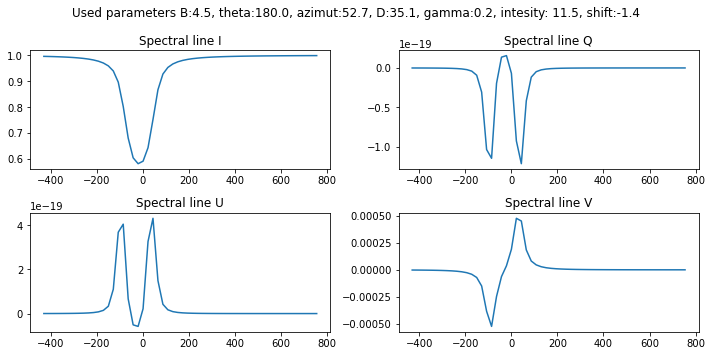

In [156]:
print("Вот здесь максимальное значение у интенсивности почти 1, потому что \n 7 и 8 параметр (источник и градиент) в сумме 1\n")
param_vec = test_params.copy()
for i in [6,7]:
    param_vec[i] = test_params[i]/np.sum(test_params[6:8])
lines0 = plot_lines(param_vec, with_ff=True, with_noise = False)
print(f'\n Максимум по линиям: {np.max(lines0):.2f}')
      

Вот здесь максимальное значение уже другое и равно должно быть сумме 7 и 8 параметра 1

Compute ME with filling factor

 Максимум по линиям: 56036.23


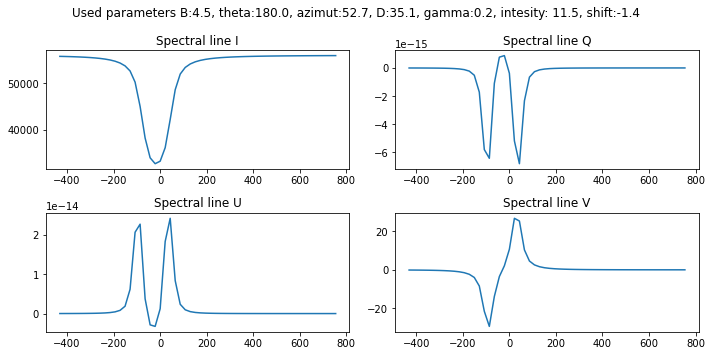

In [157]:
print("Вот здесь максимальное значение уже другое и равно должно быть сумме 7 и 8 параметра 1\n")
param_vec = test_params.copy()
lines1 = plot_lines(param_vec, with_ff=True, with_noise = False)
print(f'\n Максимум по линиям: {np.amax(lines1):.2f}')


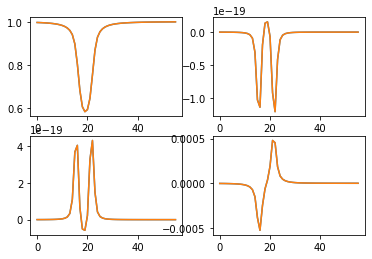

In [158]:
#если поделим их на максимумы и нарисуем то увидим что все 1 в 1 совпадает
lines0 = lines0 / np.amax(lines0)
lines1 = lines1 / np.amax(lines1)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(lines0[0,:,i])
    plt.plot(lines1[0,:,i])

###  Как мы готовим данные в сеть

мы запоминаем континум в отдельное значение, которое потом используем при обучении и генерим сразу нормированный датасет. Почему?
Ну так вроде сразу решили вопросы с нормировкой и показалось удобно. Проверим что все в порядке, в общем все в порядке



Compute ME with filling factor


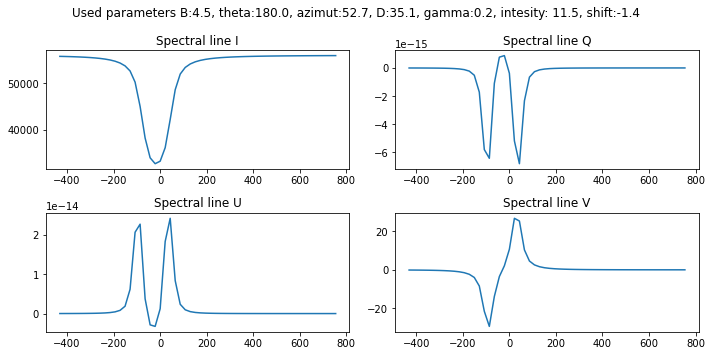

In [159]:
obj = HinodeME(test_params)
spectrum = obj.compute_spectrum(with_ff=True, with_noise=False)
lines1 = plot_lines(test_params, with_ff=True, with_noise = False)

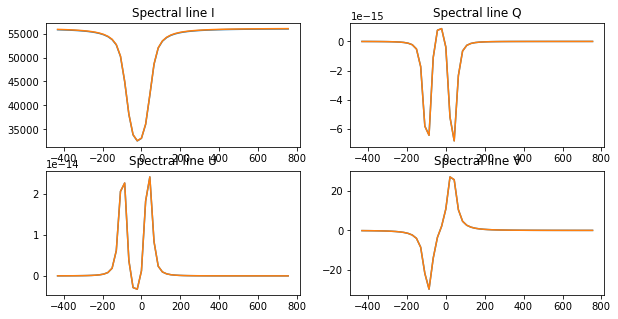

In [160]:
line_type = ['I','Q','U','V']
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(obj.line_arg, obj.cont*spectrum[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    ax[i//2][i%2].plot(obj.line_arg, lines1[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')



### НО! ШУМ !!!!

У нас вот это такая штука, хитро выдуманная

```
def generate_noise(param_vec, absolute_noise_levels=[109, 28, 28, 44], noise_size=None, mu=1):
    """
    Args:
        noise_size: shape of resulted noise
        param_vec (list or ndarray): list of 11 atmosphere parameters
        mu:
        absolute_noise_levels (list of numbers): magical empirical values

    Returns:
        noise as ndarray with the same shape as spectrum generated from param_vec
    """
    param_vec = np.array(param_vec)
    if len(param_vec.shape) == 1:
        param_vec = np.reshape(param_vec, (1, -1))
    if noise_size is None:
        noise_size = (param_vec.shape[0], 56, 4)
    cont = np.array(param_vec[:, 6] + mu * param_vec[:, 7]).reshape(-1, 1, 1)
    noise_level = np.array(absolute_noise_levels).reshape(1, 1, 4)/cont
    noise = noise_level * np.random.normal(size=noise_size)

    return noise
```
 
И я поняла, что вот этот шум прибавляется и к нормированному и ненормированному спектру одинаково. Вот это косяк конечно, надо понять как это поправить 

## TODO
Можно поправить сам me.py  - и оставить как было, либо заменять таки генерацию датасета с использованием ненормированного спектра, но потом надо менять преобразования, добавлять нормализацию 

Compute ME with filling factor

 Максимум по линиям: 56036.23


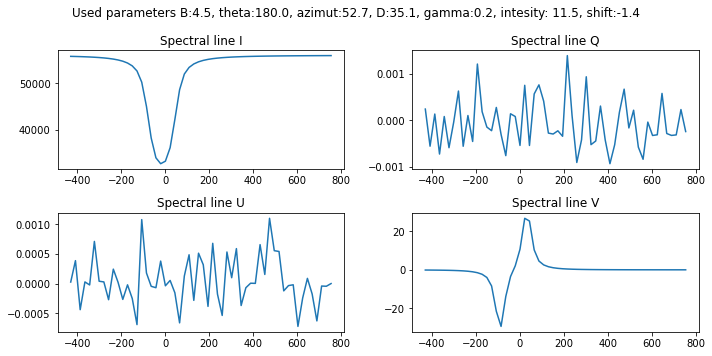

In [168]:
lines1 = plot_lines(test_params, with_ff=True, with_noise = True)
print(f'\n Максимум по линиям: {np.amax(lines1):.2f}')

In [169]:
obj = HinodeME(test_params)
spectrum = obj.compute_spectrum(with_ff=True, with_noise=True)
      

Вот тут видим что шум в линиях одинаковый, при этом сами данные отличаются нормировкой


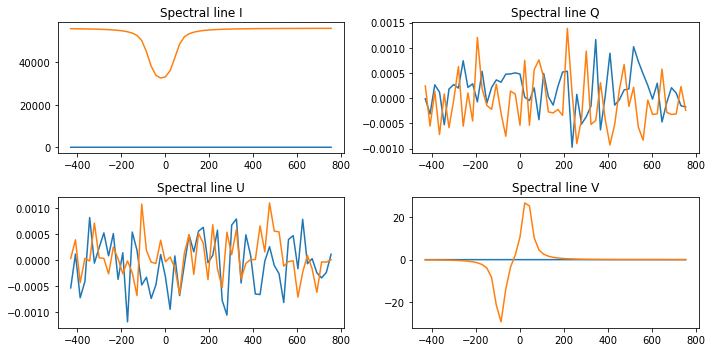

In [176]:
line_type = ['I','Q','U','V']
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(obj.line_arg, spectrum[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    ax[i//2][i%2].plot(obj.line_arg, lines1[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    fig.set_tight_layout(tight = True)

print("Вот тут видим что шум в линиях одинаковый, при этом сами данные отличаются нормировкой")

## LM
У Андрея в загруженной папочке все хорошо, но на старом коде, внутри нашей истории это будет выглядеть как-то так

In [209]:
#должны написать функцию для получаения чистого модельного профиля без шума
def me_lm_prepare(line_arg, *params):
   
    line_vec = (6302.5, 2.5, 1)
    param_vec = np.array([*params])
    lines = me_model(param_vec, line_arg, line_vec, with_ff=True, with_noise=False, norm = False)
    return lines.reshape(1,-1, order='F').T


[    4.503016     179.99996948    52.70701599    35.06171417
     0.18665825    11.48071766 29931.1640625  26170.47460938
    -1.41377854     0.39024878    -0.43512204]


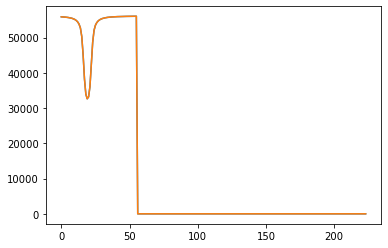

In [215]:
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56) - 6302.5)
line_vec = (6302.5, 2.5, 1)
lines = me_lm_prepare(line_arg, *test_params)
real_lines = me_model(test_params, line_arg, line_vec, with_ff=True, with_noise=True, norm = False).reshape(1,-1, order='F').T
plt.plot(lines);
plt.plot(real_lines)
print(test_params)

## И ничего не работает, а должно:(((

In [223]:
# выход out[0] - оценка, out[1] - дисперсия
out = scipy.optimize.curve_fit(me_lm_prepare, xdata = line_arg, ydata = real_lines, p0 = test_params)


ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.